# Resnet-18 

In [5]:
# imports
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim


import torchvision
from torchvision.models import resnet18
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models

Load data

In [6]:
# Transform images to 224x224 and 3 channels and normalize to work with resnet
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create datasets for training & validation
training_set = torchvision.datasets.FashionMNIST('../data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('../data', train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
# improves data retrieval, low batch size due to only finetuning
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

# Class labels
classes = ('T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

Visualise some examples

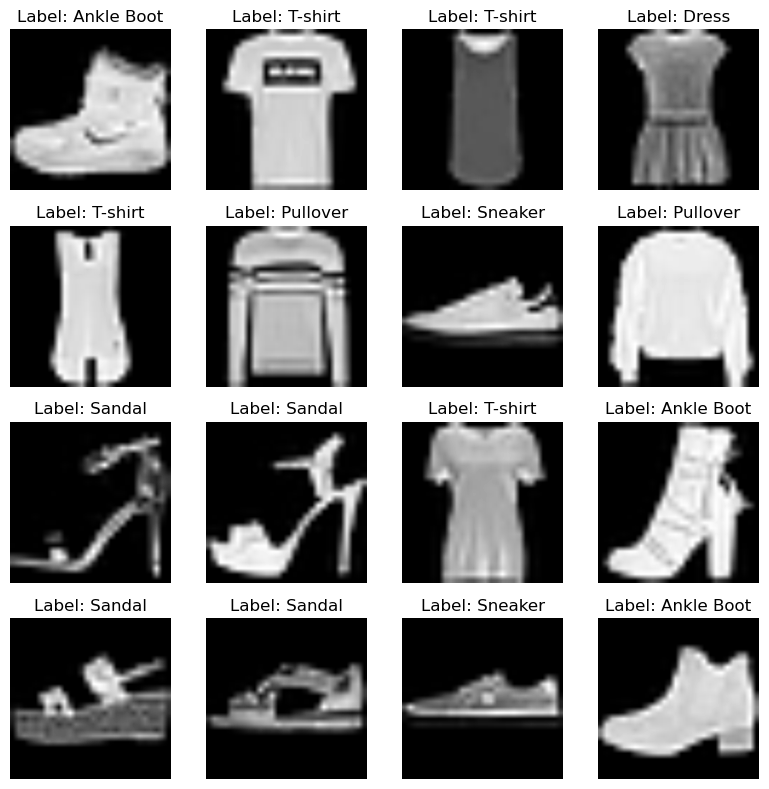

In [7]:
# Create a subplot with 4x4 grid
fig, axs = plt.subplots(4, 4, figsize=(8, 8))

# Loop through each subplot and plot an image
for i in range(4):
    for j in range(4):
        image, label = training_set[i * 4 + j]  # Get image and label
        image_numpy = image.numpy()[0,:,:]    # Convert image tensor to numpy array
        axs[i, j].imshow(image_numpy, cmap='gray')  # Plot the image
        axs[i, j].axis('off')  # Turn off axis
        axs[i, j].set_title(f"Label: {classes[label]}")  # Set title with label

plt.tight_layout()  # Adjust layout
plt.show()  # Show plot

Define Model

In [26]:
# load pretrained resnet-18
model = resnet18(weights='DEFAULT')

# replace final layer
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 10)

# Set the model to training mode and use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler to adjust the learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Finetuning the model

In [ ]:


num_epochs = 5

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in training_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Step the scheduler after each epoch
    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(training_loader):.4f}")


print('Fine-tuning complete!')

# Save the fine-tuned model
torch.save(model.state_dict(), 'finetuned_resnet18_mnist.pth')
print('Model saved!')

Evaluate Model

In [ ]:
# Set the model to evaluation mode
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in validation_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the fine-tuned model on the test images: {100 * correct / total:.2f}%')


## Visualise Loss Landscape
Effectively done by mapping high dimensional parameter space to a lower dimensional space that can be plotted and then moving along two directions in this space.

Adapted from: https://tvsujal.medium.com/visualising-the-loss-landscape-3a7bfa1c6fdf

In [ ]:
from torch.nn.utils import (
  parameters_to_vector as Params2Vec,
  vector_to_parameters as Vec2Params
)

learnt_model = 'finetuned_resnet18_mnist.pth'

learnt_net = resnet18()
learnt_net.load_state_dict(torch.load(learnt_model))
theta_ast = Params2Vec(learnt_net.parameters())

infer_net = resnet18()
theta = Params2Vec(infer_net.parameters())

loss_fn = nn.CrossEntropyLoss()

In [ ]:

def tau_2d(alpha, beta, theta_ast):
  a = alpha * theta_ast[:,None,None]
  b = beta * alpha * theta_ast[:,None,None]
  return a + b

In [ ]:
x = torch.linspace(-20, 20, 20)
y = torch.linspace(-20, 20, 20)
alpha, beta = torch.meshgrid(x, y)
space = tau_2d(alpha, beta, theta_ast)

losses = torch.empty_like(space[0, :, :])

for a, _ in enumerate(x):
  print(f'a = {a}')
  for b, _ in enumerate(y):
    Vec2Params(space[:, a, b] + theta_ast, infer_net.parameters())
    for _, (data, label) in enumerate(validation_loader):
      with torch.no_grad():
        infer_net.eval()
        losses[a][b] = loss_fn(infer_net(data), label).item()